# Channel Permutation Testing Across All Frequencies

This notebook tests all 24 possible channel permutations on each frequency dataset to find the optimal channel ordering for DOA estimation.

## Available Datasets

| Frequency | Wavelength | Array Aperture | Increments |
|-----------|------------|----------------|------------|
| 1200 MHz  | 250 mm     | 0.24λ          | 1° and 10° |
| 1500 MHz  | 200 mm     | 0.30λ          | 10°        |
| 2000 MHz  | 150 mm     | 0.40λ          | 10°        |
| 2400 MHz  | 125 mm     | 0.48λ          | 10°        |
| 3000 MHz  | 100 mm     | 0.60λ          | 10°        |
| 4000 MHz  | 75 mm      | 0.80λ          | 10°        |
| 5000 MHz  | 60 mm      | 1.00λ          | 10°        |
| 5700 MHz  | 53 mm      | 1.14λ          | 1° and 10° |
| 5800 MHz  | 52 mm      | 1.16λ          | 10°        |
| 6000 MHz  | 50 mm      | 1.20λ          | 10°        |

## 1. Setup and Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from itertools import permutations
import os

# doa_py library
from doa_py.arrays import UniformCircularArray
from doa_py.algorithm.music_based import music

# Import shared constants
from constants import CHANNEL_ORDER, RADIUS, C, DATA_DIR

# Plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

print("Setup complete!")
print(f"Using channel order: {CHANNEL_ORDER}")

## 2. Dataset Configuration

In [2]:
# All available frequency datasets
FREQ_DATASETS = {
    1200: {
        'path': '../data/1200MHz, 0dB, 10deg increments, outside',
        'freq': 1.2e9,
        'angles': list(range(0, 360, 10)),
        'color': 'blue'
    },
    1500: {
        'path': '../data/1500MHz, 0dB, 10deg increments, outside',
        'freq': 1.5e9,
        'angles': list(range(0, 360, 10)),
        'color': 'green'
    },
    2000: {
        'path': '../data/2000MHz, 0dB, 10deg increments, outside',
        'freq': 2.0e9,
        'angles': list(range(0, 360, 10)),
        'color': 'orange'
    },
    2400: {
        'path': '../data/2400MHz, 0dB, 10deg increments, outside',
        'freq': 2.4e9,
        'angles': list(range(0, 360, 10)),
        'color': 'red'
    },
    3000: {
        'path': '../data/3000MHz, 0dB, 10deg increments, outside',
        'freq': 3.0e9,
        'angles': list(range(0, 360, 10)),
        'color': 'purple'
    },
    4000: {
        'path': '../data/4000MHz, 0dB, 10deg increments, outside',
        'freq': 4.0e9,
        'angles': list(range(0, 360, 10)),
        'color': 'brown'
    },
    5000: {
        'path': '../data/5000MHz, 0dB, 10deg increments, outside',
        'freq': 5.0e9,
        'angles': list(range(0, 360, 10)),
        'color': 'pink'
    },
    5700: {
        'path': '../data/5700MHz, 0dB, 10deg increments, outside',
        'freq': 5.7e9,
        'angles': list(range(0, 360, 10)),
        'color': 'cyan'
    },
    5800: {
        'path': '../data/5800MHz, 0dB, 10deg increments, outside',
        'freq': 5.8e9,
        'angles': list(range(0, 360, 10)),
        'color': 'magenta'
    },
    6000: {
        'path': '../data/6000MHz, 0dB, 10deg increments, outside',
        'freq': 6.0e9,
        'angles': list(range(0, 360, 10)),
        'color': 'olive'
    }
}

# Check which datasets exist
print("Available datasets:")
for freq_mhz, info in sorted(FREQ_DATASETS.items()):
    exists = os.path.exists(info['path'])
    status = "✓" if exists else "✗"
    print(f"  {status} {freq_mhz} MHz: {info['path']}")

Available datasets:
  ✓ 1200 MHz: ../data/1200MHz, 0dB, 10deg increments, outside
  ✓ 1500 MHz: ../data/1500MHz, 0dB, 10deg increments, outside
  ✓ 2000 MHz: ../data/2000MHz, 0dB, 10deg increments, outside
  ✓ 2400 MHz: ../data/2400MHz, 0dB, 10deg increments, outside
  ✓ 3000 MHz: ../data/3000MHz, 0dB, 10deg increments, outside
  ✓ 4000 MHz: ../data/4000MHz, 0dB, 10deg increments, outside
  ✓ 5000 MHz: ../data/5000MHz, 0dB, 10deg increments, outside
  ✓ 5700 MHz: ../data/5700MHz, 0dB, 10deg increments, outside
  ✓ 5800 MHz: ../data/5800MHz, 0dB, 10deg increments, outside
  ✓ 6000 MHz: ../data/6000MHz, 0dB, 10deg increments, outside


## 3. Core Functions

In [ ]:
# Array parameters (from constants.py)
# RADIUS and C already imported

# Create UCA
uca = UniformCircularArray(m=4, r=RADIUS)

# Angle search grid
angle_grids = np.arange(-180, 180, 1)

def load_cs16(filepath):
    """Load a .cs16 file and return complex IQ samples."""
    raw = np.fromfile(filepath, dtype=np.int16)
    iq = raw[0::2] + 1j * raw[1::2]
    return iq

def load_measurement(base_dir, angle, channel_order=None):
    """Load all 4 channels for a given angle measurement.
    
    Args:
        base_dir: Base data directory
        angle: Measurement angle in degrees
        channel_order: List specifying channel reordering. If None, uses CHANNEL_ORDER from constants.
    """
    if channel_order is None:
        channel_order = CHANNEL_ORDER
        
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    
    raw_data = np.vstack(channels)
    return raw_data[channel_order]

def extract_tone_snapshots(X, n_snapshots=2048, fft_size=1024, freq=None):
    """Extract narrowband snapshots at the tone frequency."""
    n_channels, n_samples = X.shape
    
    fft_full = fft(X[0])
    peak_idx = np.argmax(np.abs(fft_full[1:n_samples//2])) + 1
    
    norm_freq = peak_idx / n_samples
    tone_bin = int(norm_freq * fft_size)
    
    snapshots = []
    hop = fft_size // 2
    
    for start in range(0, n_samples - fft_size, hop):
        if len(snapshots) >= n_snapshots:
            break
        segment = X[:, start:start + fft_size]
        fft_seg = fft(segment, axis=1)
        snapshot = fft_seg[:, tone_bin]
        snapshots.append(snapshot)
    
    return np.array(snapshots).T

def circular_error(est, true):
    """Calculate error handling wraparound."""
    err = est - true
    while err > 180: err -= 360
    while err < -180: err += 360
    return err

print("Core functions defined.")
print(f"Using RADIUS = {RADIUS*1000:.1f} mm")

## 4. Channel Permutation Testing Function

In [4]:
def test_permutation(X, perm, uca, freq, angle_grids, n_snapshots=2048):
    """
    Test a specific channel permutation.
    Returns the raw MUSIC estimate.
    """
    # Apply permutation
    X_perm = X[list(perm), :]
    
    # Extract snapshots
    snapshots = extract_tone_snapshots(X_perm, n_snapshots=n_snapshots, freq=freq)
    
    # MUSIC spectrum
    spectrum = music(
        received_data=snapshots,
        num_signal=1,
        array=uca,
        signal_fre=freq,
        angle_grids=angle_grids,
        unit="deg"
    )
    
    return angle_grids[np.argmax(spectrum)]

def evaluate_permutation_on_dataset(freq_mhz, info, perm, test_angles=None, n_snapshots=2048):
    """
    Evaluate a permutation across multiple angles.
    Returns RMSE and list of errors.
    """
    if test_angles is None:
        test_angles = info['angles']
    
    errors = []
    
    for true_angle in test_angles:
        try:
            X = load_measurement(info['path'], true_angle)
            est = test_permutation(X, perm, uca, info['freq'], angle_grids, n_snapshots)
            
            true_adj = true_angle if true_angle <= 180 else true_angle - 360
            err = circular_error(est, true_adj)
            errors.append(err)
        except Exception as e:
            pass
    
    if errors:
        rmse = np.sqrt(np.mean(np.array(errors)**2))
        return rmse, errors
    return None, []

# All 24 permutations of 4 channels
ALL_PERMUTATIONS = list(permutations([0, 1, 2, 3]))
print(f"Total permutations to test: {len(ALL_PERMUTATIONS)}")

Total permutations to test: 24


## 5. Brute Force All Permutations on All Frequencies

Test all 24 channel permutations on each frequency dataset.

In [5]:
# Run brute force permutation test on all frequencies
results = {}

print("=" * 80)
print("BRUTE FORCE CHANNEL PERMUTATION TEST - ALL FREQUENCIES")
print("=" * 80)

for freq_mhz in sorted(FREQ_DATASETS.keys()):
    info = FREQ_DATASETS[freq_mhz]
    
    if not os.path.exists(info['path']):
        print(f"\n{freq_mhz} MHz: SKIPPED (data not found)")
        continue
    
    print(f"\n{freq_mhz} MHz: Testing {len(ALL_PERMUTATIONS)} permutations...")
    
    perm_results = []
    
    for i, perm in enumerate(ALL_PERMUTATIONS):
        rmse, errors = evaluate_permutation_on_dataset(freq_mhz, info, perm)
        if rmse is not None:
            perm_results.append({
                'perm': perm,
                'rmse': rmse,
                'mean_err': np.mean(errors),
                'errors': errors
            })
        
        # Progress indicator
        if (i + 1) % 6 == 0:
            print(f"  Tested {i + 1}/24 permutations...")
    
    # Sort by RMSE
    perm_results.sort(key=lambda x: x['rmse'])
    results[freq_mhz] = perm_results
    
    # Show top 3
    print(f"\n  Top 3 permutations for {freq_mhz} MHz:")
    for j, res in enumerate(perm_results[:3]):
        print(f"    {j+1}. {res['perm']} -> RMSE: {res['rmse']:.1f}°, Mean: {res['mean_err']:+.1f}°")

print("\n" + "=" * 80)
print("COMPLETE!")
print("=" * 80)

BRUTE FORCE CHANNEL PERMUTATION TEST - ALL FREQUENCIES

1200 MHz: Testing 24 permutations...
  Tested 6/24 permutations...
  Tested 12/24 permutations...
  Tested 18/24 permutations...
  Tested 24/24 permutations...

  Top 3 permutations for 1200 MHz:
    1. (0, 1, 2, 3) -> RMSE: 53.5°, Mean: +19.3°
    2. (0, 2, 1, 3) -> RMSE: 69.8°, Mean: -31.4°
    3. (3, 1, 2, 0) -> RMSE: 76.5°, Mean: +21.4°

1500 MHz: Testing 24 permutations...
  Tested 6/24 permutations...
  Tested 12/24 permutations...
  Tested 18/24 permutations...
  Tested 24/24 permutations...

  Top 3 permutations for 1500 MHz:
    1. (0, 2, 1, 3) -> RMSE: 70.8°, Mean: -9.0°
    2. (3, 2, 1, 0) -> RMSE: 92.3°, Mean: -12.6°
    3. (1, 2, 0, 3) -> RMSE: 95.0°, Mean: -1.0°

2000 MHz: Testing 24 permutations...
  Tested 6/24 permutations...
  Tested 12/24 permutations...
  Tested 18/24 permutations...
  Tested 24/24 permutations...

  Top 3 permutations for 2000 MHz:
    1. (1, 2, 0, 3) -> RMSE: 76.2°, Mean: +9.8°
    2. (1, 2, 

## 6. Summary: Best Permutation Per Frequency

In [6]:
# Summary table
print("=" * 80)
print("BEST CHANNEL PERMUTATION FOR EACH FREQUENCY")
print("=" * 80)
print(f"\n{'Frequency':>10} | {'Best Perm':>15} | {'RMSE':>10} | {'Mean Err':>10} | {'Worst Perm':>15} | {'Worst RMSE':>10}")
print("-" * 80)

best_perms = {}

for freq_mhz in sorted(results.keys()):
    perm_results = results[freq_mhz]
    if not perm_results or len(perm_results) == 0:
        print(f"{freq_mhz:>8} MHz | {'NO DATA':>15} | {'-':>10} | {'-':>10} | {'-':>15} | {'-':>10}")
        continue
    
    best = perm_results[0]
    worst = perm_results[-1]
    best_perms[freq_mhz] = best['perm']
    
    print(f"{freq_mhz:>8} MHz | {str(best['perm']):>15} | {best['rmse']:>8.1f}° | {best['mean_err']:>+8.1f}° | {str(worst['perm']):>15} | {worst['rmse']:>8.1f}°")

print("=" * 80)

BEST CHANNEL PERMUTATION FOR EACH FREQUENCY

 Frequency |       Best Perm |       RMSE |   Mean Err |      Worst Perm | Worst RMSE
--------------------------------------------------------------------------------
    1200 MHz |    (0, 1, 2, 3) |     53.5° |    +19.3° |    (2, 3, 0, 1) |    140.4°
    1500 MHz |    (0, 2, 1, 3) |     70.8° |     -9.0° |    (1, 3, 0, 2) |    128.9°
    2000 MHz |    (1, 2, 0, 3) |     76.2° |     +9.8° |    (0, 3, 1, 2) |    126.7°
    2400 MHz |    (0, 1, 2, 3) |     67.0° |     +8.9° |    (0, 3, 2, 1) |    128.1°
    3000 MHz |    (1, 2, 0, 3) |     64.9° |    -12.0° |    (0, 3, 1, 2) |    136.1°
    4000 MHz |    (2, 1, 0, 3) |     87.5° |    +32.8° |    (3, 0, 2, 1) |    115.6°
    5000 MHz |    (1, 2, 0, 3) |     90.6° |    +11.8° |    (1, 3, 2, 0) |    115.9°
    5700 MHz |    (1, 3, 0, 2) |     86.5° |    +28.4° |    (2, 1, 3, 0) |    121.1°
    5800 MHz |    (0, 2, 3, 1) |     84.3° |     -5.4° |    (0, 3, 2, 1) |    118.9°
    6000 MHz |    (3, 2

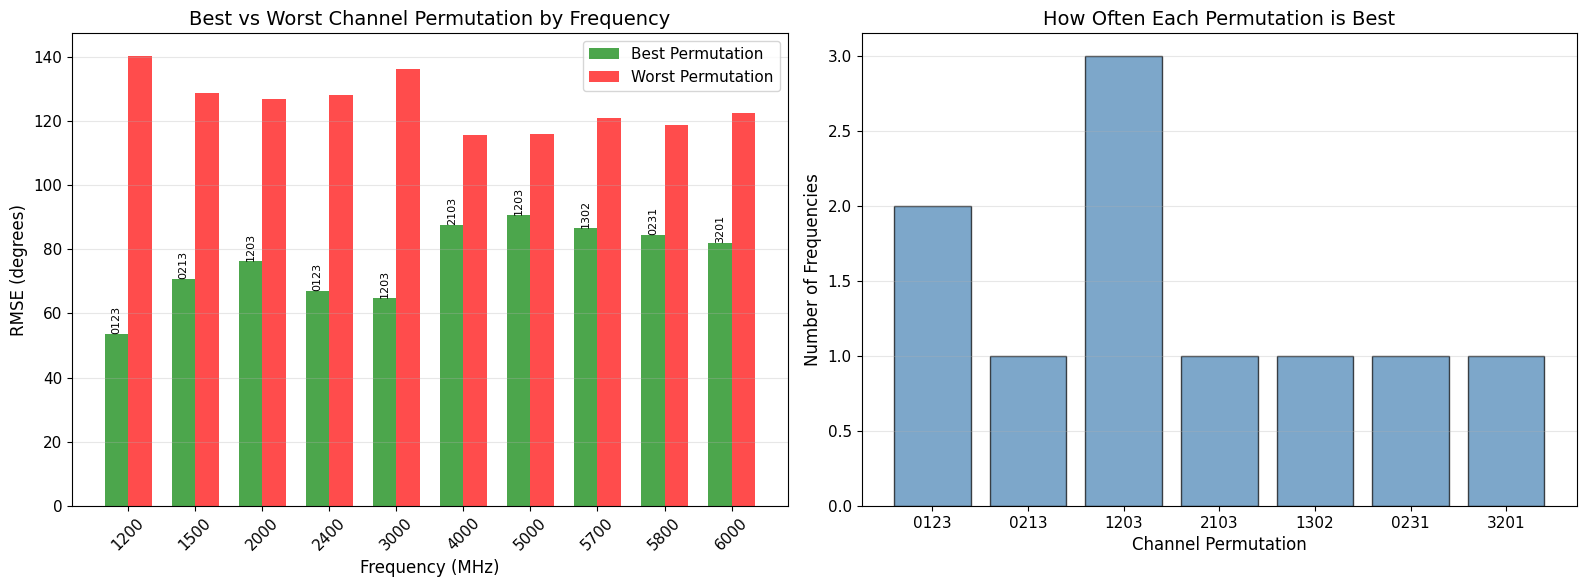

In [7]:
# Visualization: RMSE by frequency with best permutation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Filter frequencies that have results
freqs = [f for f in sorted(results.keys()) if results[f] and len(results[f]) > 0]

if not freqs:
    print("No results to plot!")
else:
    # Bar chart of best RMSE per frequency
    ax = axes[0]
    best_rmses = [results[f][0]['rmse'] for f in freqs]
    worst_rmses = [results[f][-1]['rmse'] for f in freqs]

    x = np.arange(len(freqs))
    width = 0.35

    bars1 = ax.bar(x - width/2, best_rmses, width, label='Best Permutation', color='green', alpha=0.7)
    bars2 = ax.bar(x + width/2, worst_rmses, width, label='Worst Permutation', color='red', alpha=0.7)

    ax.set_xlabel('Frequency (MHz)', fontsize=12)
    ax.set_ylabel('RMSE (degrees)', fontsize=12)
    ax.set_title('Best vs Worst Channel Permutation by Frequency', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([str(f) for f in freqs], rotation=45)
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)

    # Show best permutation labels
    for i, (f, rmse) in enumerate(zip(freqs, best_rmses)):
        perm_str = ''.join(map(str, best_perms[f]))
        ax.annotate(perm_str, (i - width/2, rmse), ha='center', va='bottom', fontsize=8, rotation=90)

    # Heatmap of permutation consistency
    ax = axes[1]
    perm_counts = {}
    for freq_mhz in freqs:
        perm = best_perms[freq_mhz]
        perm_str = ''.join(map(str, perm))
        perm_counts[perm_str] = perm_counts.get(perm_str, 0) + 1

    perm_labels = list(perm_counts.keys())
    perm_values = list(perm_counts.values())

    ax.bar(perm_labels, perm_values, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Channel Permutation', fontsize=12)
    ax.set_ylabel('Number of Frequencies', fontsize=12)
    ax.set_title('How Often Each Permutation is Best', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

## 7. Detailed Analysis: Do Different Frequencies Need Different Permutations?

In [8]:
# Check if (0,1,2,3) is consistently good or if other permutations help
print("=" * 80)
print("ANALYSIS: Performance of Standard (0,1,2,3) vs Best Permutation")
print("=" * 80)

standard_perm = (0, 1, 2, 3)

print(f"\n{'Frequency':>10} | {'(0,1,2,3) RMSE':>15} | {'Best RMSE':>12} | {'Best Perm':>15} | {'Improvement':>12}")
print("-" * 80)

for freq_mhz in sorted(results.keys()):
    perm_results = results[freq_mhz]
    if not perm_results or len(perm_results) == 0:
        continue
    
    # Find (0,1,2,3) result
    std_result = next((r for r in perm_results if r['perm'] == standard_perm), None)
    best_result = perm_results[0]
    
    if std_result:
        improvement = std_result['rmse'] - best_result['rmse']
        imp_pct = improvement / std_result['rmse'] * 100 if std_result['rmse'] > 0 else 0
        
        print(f"{freq_mhz:>8} MHz | {std_result['rmse']:>13.1f}° | {best_result['rmse']:>10.1f}° | {str(best_result['perm']):>15} | {improvement:>+6.1f}° ({imp_pct:>+5.1f}%)")

print("=" * 80)

ANALYSIS: Performance of Standard (0,1,2,3) vs Best Permutation

 Frequency |  (0,1,2,3) RMSE |    Best RMSE |       Best Perm |  Improvement
--------------------------------------------------------------------------------
    1200 MHz |          53.5° |       53.5° |    (0, 1, 2, 3) |   +0.0° ( +0.0%)
    1500 MHz |          96.5° |       70.8° |    (0, 2, 1, 3) |  +25.7° (+26.6%)
    2000 MHz |          87.6° |       76.2° |    (1, 2, 0, 3) |  +11.4° (+13.0%)
    2400 MHz |          67.0° |       67.0° |    (0, 1, 2, 3) |   +0.0° ( +0.0%)
    3000 MHz |          87.5° |       64.9° |    (1, 2, 0, 3) |  +22.6° (+25.9%)
    4000 MHz |         100.1° |       87.5° |    (2, 1, 0, 3) |  +12.6° (+12.6%)
    5000 MHz |         115.4° |       90.6° |    (1, 2, 0, 3) |  +24.8° (+21.5%)
    5700 MHz |          99.6° |       86.5° |    (1, 3, 0, 2) |  +13.1° (+13.2%)
    5800 MHz |         103.2° |       84.3° |    (0, 2, 3, 1) |  +18.9° (+18.3%)
    6000 MHz |          96.8° |       81.8° |   

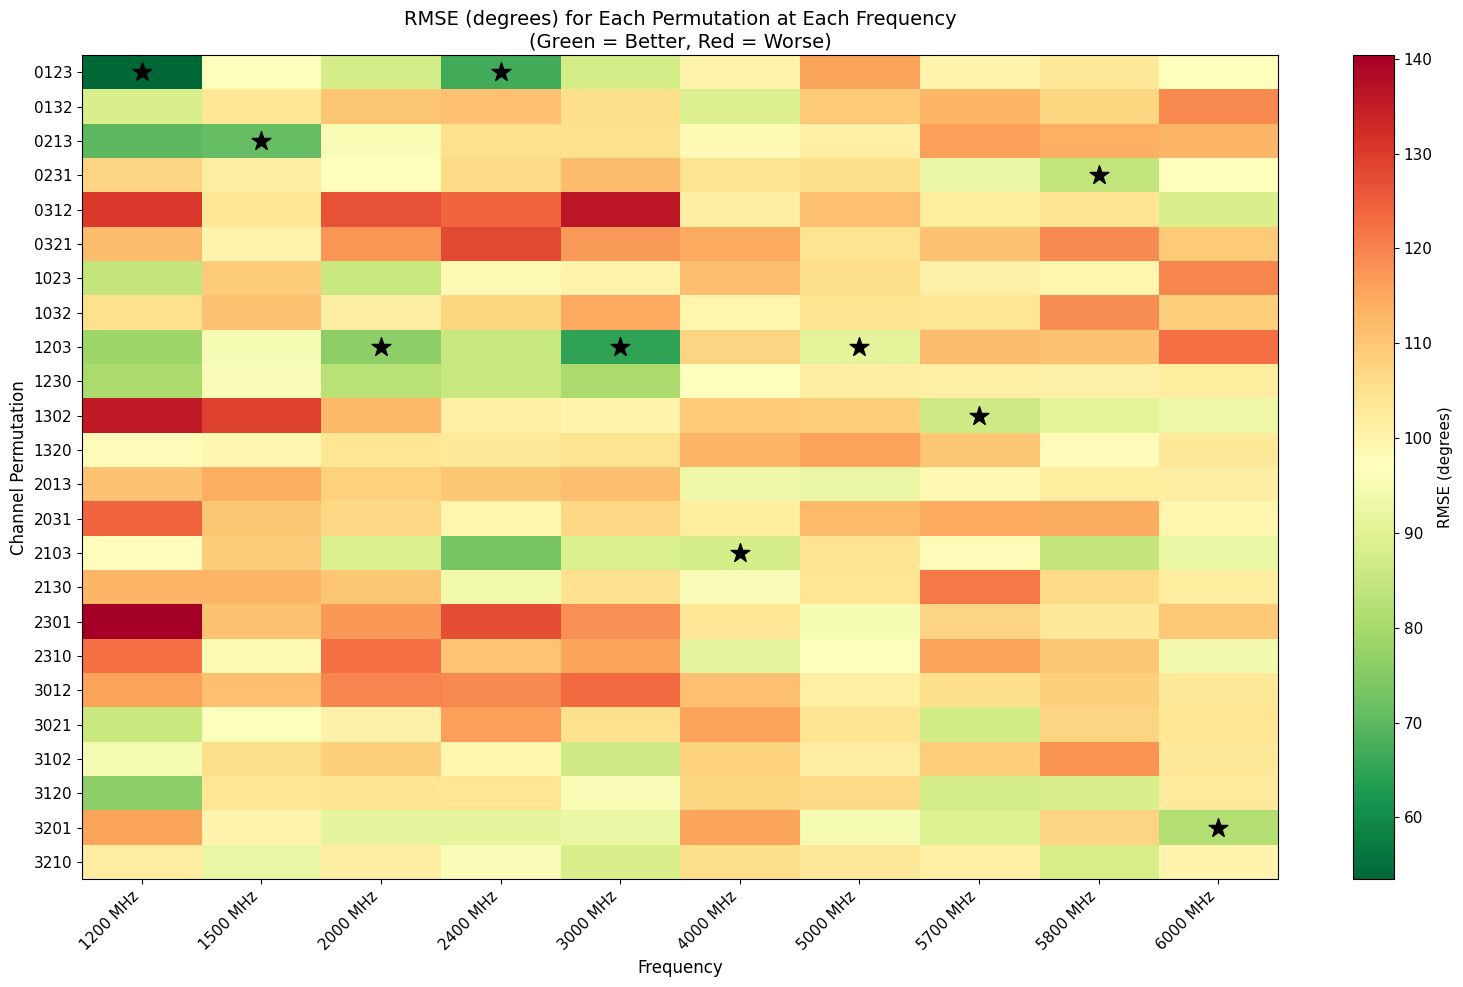

In [9]:
# Heatmap: All permutations vs all frequencies
freqs = [f for f in sorted(results.keys()) if results[f] and len(results[f]) > 0]

if not freqs:
    print("No results to plot!")
else:
    fig, ax = plt.subplots(figsize=(16, 10))

    perm_labels = [''.join(map(str, p)) for p in ALL_PERMUTATIONS]

    # Build matrix
    rmse_matrix = np.zeros((len(ALL_PERMUTATIONS), len(freqs)))

    for j, freq_mhz in enumerate(freqs):
        perm_results = results[freq_mhz]
        for res in perm_results:
            i = ALL_PERMUTATIONS.index(res['perm'])
            rmse_matrix[i, j] = res['rmse']

    im = ax.imshow(rmse_matrix, aspect='auto', cmap='RdYlGn_r')

    ax.set_xticks(range(len(freqs)))
    ax.set_xticklabels([f'{f} MHz' for f in freqs], rotation=45, ha='right')
    ax.set_yticks(range(len(ALL_PERMUTATIONS)))
    ax.set_yticklabels(perm_labels)

    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_ylabel('Channel Permutation', fontsize=12)
    ax.set_title('RMSE (degrees) for Each Permutation at Each Frequency\n(Green = Better, Red = Worse)', fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('RMSE (degrees)', fontsize=11)

    # Mark best permutation per frequency
    for j, freq_mhz in enumerate(freqs):
        if freq_mhz in best_perms:
            best_perm = best_perms[freq_mhz]
            i = ALL_PERMUTATIONS.index(best_perm)
            ax.scatter(j, i, marker='*', s=200, c='black', zorder=10)

    plt.tight_layout()
    plt.show()

## 8. Test with Rotation Offset Correction

Now let's test permutations with rotation offset correction to see if combining both helps.

In [ ]:
def evaluate_perm_with_offset(freq_mhz, info, perm, offset, n_snapshots=2048):
    """Evaluate permutation with rotation offset correction."""
    errors = []
    
    for true_angle in info['angles']:
        try:
            X = load_measurement(info['path'], true_angle)
            est = test_permutation(X, perm, uca, info['freq'], angle_grids, n_snapshots)
            
            # Apply rotation offset
            est_corr = est - offset
            
            true_adj = true_angle if true_angle <= 180 else true_angle - 360
            err = circular_error(est_corr, true_adj)
            errors.append(err)
        except:
            pass
    
    if errors:
        return np.sqrt(np.mean(np.array(errors)**2))
    return None

# For each frequency, find best (permutation, offset) combination
print("=" * 80)
print("OPTIMIZING PERMUTATION + ROTATION OFFSET")
print("=" * 80)

OFFSET_RANGE = range(0, 90, 5)
optimal_configs = {}

# Filter to frequencies with results
freqs_with_results = [f for f in sorted(results.keys()) if results[f] and len(results[f]) > 0]

for freq_mhz in freqs_with_results:
    info = FREQ_DATASETS[freq_mhz]
    print(f"\n{freq_mhz} MHz: Testing permutations with offsets...")
    
    # Only test top 5 permutations (to save time)
    top_perms = [r['perm'] for r in results[freq_mhz][:5]]
    
    best_rmse = float('inf')
    best_config = None
    
    for perm in top_perms:
        for offset in OFFSET_RANGE:
            rmse = evaluate_perm_with_offset(freq_mhz, info, perm, offset)
            if rmse is not None and rmse < best_rmse:
                best_rmse = rmse
                best_config = {'perm': perm, 'offset': offset, 'rmse': rmse}
    
    # Fine-tune offset
    if best_config:
        fine_range = range(max(0, best_config['offset'] - 5), min(90, best_config['offset'] + 6))
        for offset in fine_range:
            rmse = evaluate_perm_with_offset(freq_mhz, info, best_config['perm'], offset)
            if rmse is not None and rmse < best_rmse:
                best_rmse = rmse
                best_config = {'perm': best_config['perm'], 'offset': offset, 'rmse': rmse}
    
    if best_config:
        optimal_configs[freq_mhz] = best_config
        print(f"  Best: perm={best_config['perm']}, offset={best_config['offset']}°, RMSE={best_config['rmse']:.1f}°")
    else:
        print(f"  No valid configuration found")

print("\n" + "=" * 80)

OPTIMIZING PERMUTATION + ROTATION OFFSET

1200 MHz: Testing permutations with offsets...


In [ ]:
# Final comparison: Raw permutation vs Permutation + Offset
print("=" * 80)
print("FINAL RESULTS: Best Configuration Per Frequency")
print("=" * 80)

print(f"\n{'Frequency':>10} | {'Best Perm':>12} | {'Offset':>8} | {'RMSE':>10} | {'vs (0,1,2,3)':>15}")
print("-" * 80)

for freq_mhz in sorted(optimal_configs.keys()):
    cfg = optimal_configs[freq_mhz]
    
    # Get standard permutation RMSE for comparison
    std_result = next((r for r in results[freq_mhz] if r['perm'] == (0,1,2,3)), None)
    if std_result:
        improvement = std_result['rmse'] - cfg['rmse']
        perm_str = ''.join(map(str, cfg['perm']))
        print(f"{freq_mhz:>8} MHz | {perm_str:>12} | {cfg['offset']:>6}° | {cfg['rmse']:>8.1f}° | {improvement:>+13.1f}°")
    else:
        perm_str = ''.join(map(str, cfg['perm']))
        print(f"{freq_mhz:>8} MHz | {perm_str:>12} | {cfg['offset']:>6}° | {cfg['rmse']:>8.1f}° | {'N/A':>15}")

print("=" * 80)

## 9. Summary and Conclusions

In [ ]:
# Final summary visualization
if not optimal_configs:
    print("No optimal configurations found!")
else:
    fig, ax = plt.subplots(figsize=(14, 6))

    freqs = sorted(optimal_configs.keys())
    optimized_rmse = [optimal_configs[f]['rmse'] for f in freqs]
    standard_rmse = []
    for f in freqs:
        std_res = next((r['rmse'] for r in results[f] if r['perm'] == (0,1,2,3)), None)
        standard_rmse.append(std_res if std_res else 0)

    x = np.arange(len(freqs))
    width = 0.35

    bars1 = ax.bar(x - width/2, standard_rmse, width, label='Standard (0,1,2,3)', color='gray', alpha=0.7)
    bars2 = ax.bar(x + width/2, optimized_rmse, width, label='Optimized (perm + offset)', color='green', alpha=0.7)

    ax.set_xlabel('Frequency (MHz)', fontsize=12)
    ax.set_ylabel('RMSE (degrees)', fontsize=12)
    ax.set_title('DOA Estimation RMSE: Standard vs Optimized Configuration', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels([str(f) for f in freqs], rotation=45)
    ax.legend()
    ax.grid(True, axis='y', alpha=0.3)

    # Add optimized config labels
    for i, f in enumerate(freqs):
        cfg = optimal_configs[f]
        perm_str = ''.join(map(str, cfg['perm']))
        ax.annotate(f"{perm_str}\n{cfg['offset']}°", 
                    (i + width/2, optimized_rmse[i]), 
                    ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print final config table
    print("\n" + "=" * 70)
    print("RECOMMENDED CONFIGURATION FOR EACH FREQUENCY")
    print("=" * 70)
    print("""
Copy these settings for your DOA estimation:
""")
    for freq_mhz in sorted(optimal_configs.keys()):
        cfg = optimal_configs[freq_mhz]
        print(f"  {freq_mhz:>4} MHz: channel_order={cfg['perm']}, rotation_offset={cfg['offset']}°, expected_rmse={cfg['rmse']:.1f}°")
    print("\n" + "=" * 70)